<html><h1><center style="color:blue">Applying LSTM Models on Raw Data</center></h1></html>


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, BatchNormalization, Input
from keras.regularizers import L1L2
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf



In [2]:
# Activities as class labels
ACTIVITIES = {
    0: 'WALKING',
    1: 'WALKING_UPSTAIRS',
    2: 'WALKING_DOWNSTAIRS',
    3: 'SITTING',
    4: 'STANDING',
    5: 'LAYING',
}


In [3]:
# function to print the confusion matrix

def new_confusion_matrix(Y_true, Y_pred):
    Y_true = np.argmax(Y_true, axis=1)
    Y_pred = np.argmax(Y_pred, axis=1)
    cm = confusion_matrix(Y_true, Y_pred)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=list(ACTIVITIES.values()),
                yticklabels=list(ACTIVITIES.values()))
    plt.title("Confusion Matrix")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show() 


<html><h1><p style="color:red">Loading Data / Making Data </p></h1></html>


In [4]:
# Data directory
DATADIR = 'UCI_HAR_Dataset'

# Raw data signals
# Signals are from Accelerometer and Gyroscope
# The signals are in x,y,z directions
# Sensor signals are filtered to have only body acceleration
# excluding the acceleration due to gravity
# Triaxial acceleration from the accelerometer is total acceleration
SIGNALS = [
    "body_acc_x",
    "body_acc_y",
    "body_acc_z",
    "body_gyro_x",
    "body_gyro_y",
    "body_gyro_z",
    "total_acc_x",
    "total_acc_y",
    "total_acc_z"
    ]


In [5]:
# function to read the data from csv file
def _read_csv(filename):
    return pd.read_csv(filename, sep=r'\s+', header=None)

# function to load the load
def load_signals(subset):
    signals_data = []

    for signal in SIGNALS:
        filename = f'UCI HAR Dataset/{subset}/Inertial Signals/{signal}_{subset}.txt'
        signals_data.append(
            _read_csv(filename).to_numpy()
        ) 

    # Transpose is used to change the dimensionality of the output,
    # aggregating the signals by combination of sample/timestep.
    # Resultant shape is (7352 train/2947 test samples, 128 timesteps, 9 signals)
    return np.transpose(signals_data, (1, 2, 0))


In [6]:
def load_y(subset):
    """
    The objective that we are trying to predict is a integer, from 1 to 6,
    that represents a human activity. We return a binary representation of 
    every sample objective as a 6 bits vector using One Hot Encoding
    (https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html)
    """
    filename = f'UCI HAR Dataset/{subset}/y_{subset}.txt'
    y = _read_csv(filename)[0]

    return pd.get_dummies(y).to_numpy()


In [7]:
def load_data():
    """
    Obtain the dataset from multiple files.
    Returns: X_train, X_test, y_train, y_test
    """
    X_train, X_test = load_signals('train'), load_signals('test')
    y_train, y_test = load_y('train'), load_y('test')

    return X_train, X_test, y_train, y_test


In [8]:
# Importing tensorflow
np.random.seed(42)
tf.random.set_seed(42)


In [9]:
# Initializing parameters
epochs = 30
batch_size = 16
n_hidden = 32


In [10]:
#function to count the number of classes
def _count_classes(y):
    return len(set([tuple(category) for category in y]))


In [11]:
# Loading the train and test data
X_train, X_test, Y_train, Y_test = load_data()


In [12]:
timesteps = len(X_train[0])
input_dim = len(X_train[0][0])
n_classes = _count_classes(Y_train)

print(timesteps)
print(input_dim)
print(len(X_train))


128
9
7352


<html><h1><p style="color:red">1. Defining the Architecture of 1-Layer of LSTM </p></h1></html>


In [13]:
# Initiliazing the sequential model
model = Sequential([
    Input(shape=(timesteps, input_dim)),
    LSTM(32),
    Dropout(0.5),
    Dense(n_classes, activation='sigmoid')
])
print("Model Summary: ")
model.summary()


Model Summary: 


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 32)             │         5,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6)              │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,574 (21.77 KB)

 Trainable params: 5,574 (21.77 KB)

 Non-trainable params: 0 (0.00 B)

In [37]:
# Compiling the model
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])


In [38]:
# Training the model
model.fit(X_train, Y_train, batch_size=batch_size, validation_data=(X_test, Y_test),epochs=epochs)


Epoch 1/30
460/460 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - accuracy: 0.4269 - loss: 1.3689 - val_accuracy: 0.4418 - val_loss: 1.2091
Epoch 2/30
460/460 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.6270 - loss: 0.8517 - val_accuracy: 0.6776 - val_loss: 0.7773
Epoch 3/30
460/460 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.7003 - loss: 0.7129 - val_accuracy: 0.7689 - val_loss: 0.6340
Epoch 4/30
460/460 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.7953 - loss: 0.5465 - val_accuracy: 0.7940 - val_loss: 0.5757
Epoch 5/30
460/460 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - accuracy: 0.8657 - loss: 0.4253 - val_accuracy: 0.8568 - val_loss: 0.4843
Epoch 6/30
460/460 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.8972 - loss: 0.3327 - val_accuracy: 0.8473 - val_loss: 0.5450
Epoch 7/30
460/460 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - accuracy: 0.9070 - loss: 0.2904 - val_accuracy: 0.8554 - val_loss: 0.5197
Epoch 8/30
460/460 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - accuracy: 0.9164 - loss: 0.2490 - va

93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


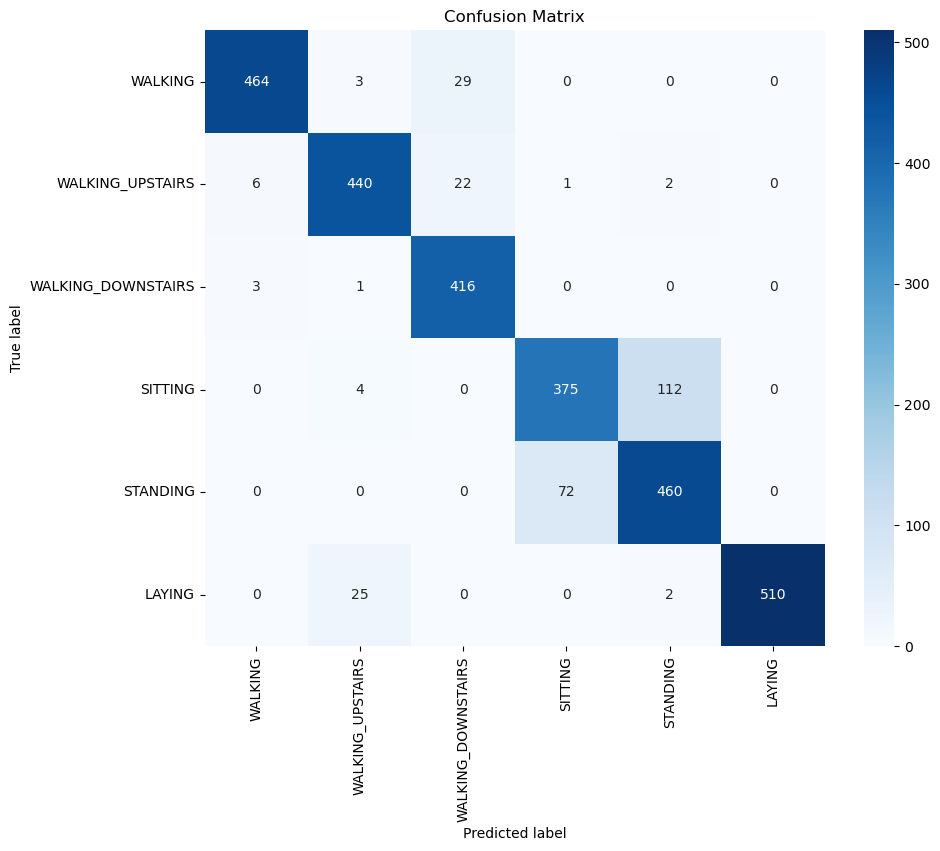

In [39]:
# Confusion Matrix
new_confusion_matrix(Y_test, model.predict(X_test))


In [40]:
score = model.evaluate(X_test, Y_test)
print(f"Loss: {score[0]:.4f}, Accuracy: {score[1]:.4f}")


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8698 - loss: 0.5862
Loss: 0.5034, Accuracy: 0.9043


<html><h3><p style="color:#008080">With a simple 1 layer architecture we got 90.43% accuracy and a loss of 0.50</p></h4></html>


<html><h1><p style="color:red">2. Defining the Architecture of 2-Layer of LSTM with more hyperparameter tunning </p></h1></html>


### 2.1 First Model for 2-Layer of LSTM with more hyperparameter tunning


In [18]:
# Initializing parameters
n_epochs = 30
n_batch = 16
n_classes = _count_classes(Y_train)

# Bias regularizer value - we will use elasticnet
reg = L1L2(0.01, 0.01)


In [42]:
# Model execution
model = Sequential([
    Input(shape=(timesteps, input_dim)),
    LSTM(48, return_sequences=True, bias_regularizer=reg),
    BatchNormalization(),
    Dropout(0.50),
    LSTM(32),
    Dropout(0.50),
    Dense(n_classes, activation='softmax')
])
print("Model Summary: ")
model.summary()


Model Summary: 


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 128, 48)        │        11,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 48)        │           192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128, 48)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)             │        10,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,894 (85.52 KB)

 Trainable params: 21,798 (85.15 KB)

 Non-trainable params: 96 (384.00 B)

In [43]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [44]:
# Training the model
model.fit(X_train, Y_train, batch_size=n_batch, validation_data=(X_test, Y_test), epochs=n_epochs)


Epoch 1/30
460/460 ━━━━━━━━━━━━━━━━━━━━ 29s 53ms/step - accuracy: 0.5939 - loss: 1.8872 - val_accuracy: 0.7845 - val_loss: 1.0715
Epoch 2/30
460/460 ━━━━━━━━━━━━━━━━━━━━ 22s 49ms/step - accuracy: 0.8135 - loss: 0.9286 - val_accuracy: 0.8680 - val_loss: 0.6113
Epoch 3/30
460/460 ━━━━━━━━━━━━━━━━━━━━ 23s 49ms/step - accuracy: 0.9032 - loss: 0.4846 - val_accuracy: 0.8283 - val_loss: 0.5465
Epoch 4/30
460/460 ━━━━━━━━━━━━━━━━━━━━ 28s 60ms/step - accuracy: 0.9158 - loss: 0.3068 - val_accuracy: 0.7781 - val_loss: 0.6835
Epoch 5/30
460/460 ━━━━━━━━━━━━━━━━━━━━ 26s 57ms/step - accuracy: 0.9235 - loss: 0.2493 - val_accuracy: 0.9118 - val_loss: 0.3109
Epoch 6/30
460/460 ━━━━━━━━━━━━━━━━━━━━ 28s 61ms/step - accuracy: 0.9378 - loss: 0.1935 - val_accuracy: 0.7805 - val_loss: 1.1354
Epoch 7/30
460/460 ━━━━━━━━━━━━━━━━━━━━ 26s 57ms/step - accuracy: 0.9180 - loss: 0.2533 - val_accuracy: 0.9074 - val_loss: 0.3125
Epoch 8/30
460/460 ━━━━━━━━━━━━━━━━━━━━ 29s 64ms/step - accuracy: 0.9360 - loss: 0.1762 - 

93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step


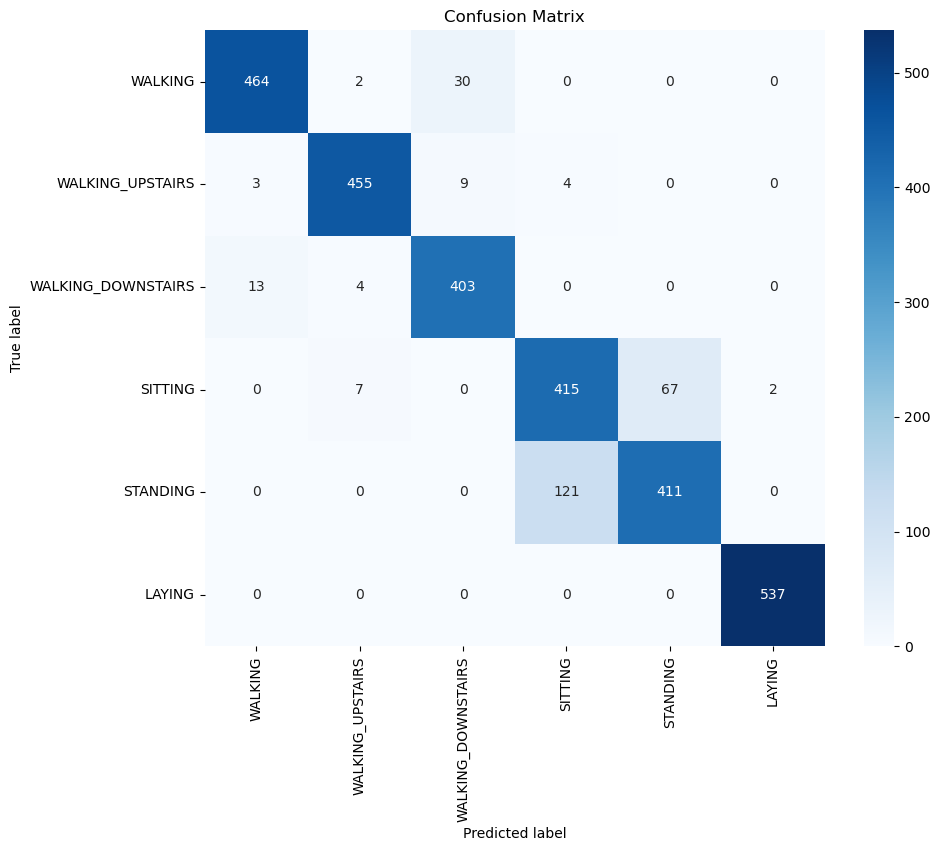

In [45]:
# Confusion Matrix
new_confusion_matrix(Y_test, model.predict(X_test))


In [46]:
score = model.evaluate(X_test, Y_test)
print(f"Loss: {score[0]:.4f}, Accuracy: {score[1]:.4f}")


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.8617 - loss: 0.4073
Loss: 0.3406, Accuracy: 0.9111


### 2.2 Second Model for 2-Layer of LSTM with more hyperparameter tunning


In [19]:
# Model execution
model = Sequential([
    Input(shape=(timesteps, input_dim)),
    LSTM(64, return_sequences=True, bias_regularizer=reg),
    BatchNormalization(),
    Dropout(0.50),
    LSTM(48),
    Dropout(0.50),
    Dense(n_classes, activation='softmax')
])
print("Model Summary: ")
model.summary()


Model Summary: 


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 128, 64)        │        18,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 48)             │        21,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 48)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │           294 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 41,190 (160.90 KB)

 Trainable params: 41,062 (160.40 KB)

 Non-trainable params: 128 (512.00 B)

In [20]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [21]:
# Training the model
model.fit(X_train, Y_train, batch_size=n_batch, validation_data=(X_test, Y_test), epochs=n_epochs)


Epoch 1/30
460/460 ━━━━━━━━━━━━━━━━━━━━ 26s 48ms/step - accuracy: 0.6137 - loss: 2.0791 - val_accuracy: 0.7540 - val_loss: 1.2565
Epoch 2/30
460/460 ━━━━━━━━━━━━━━━━━━━━ 33s 72ms/step - accuracy: 0.8820 - loss: 0.8519 - val_accuracy: 0.8724 - val_loss: 0.6354
Epoch 3/30
460/460 ━━━━━━━━━━━━━━━━━━━━ 30s 64ms/step - accuracy: 0.9197 - loss: 0.4171 - val_accuracy: 0.8839 - val_loss: 0.3864
Epoch 4/30
460/460 ━━━━━━━━━━━━━━━━━━━━ 30s 64ms/step - accuracy: 0.9250 - loss: 0.2292 - val_accuracy: 0.8748 - val_loss: 0.3608
Epoch 5/30
460/460 ━━━━━━━━━━━━━━━━━━━━ 30s 65ms/step - accuracy: 0.9297 - loss: 0.1941 - val_accuracy: 0.9002 - val_loss: 0.3376
Epoch 6/30
460/460 ━━━━━━━━━━━━━━━━━━━━ 29s 64ms/step - accuracy: 0.9392 - loss: 0.1728 - val_accuracy: 0.9016 - val_loss: 0.2441
Epoch 7/30
460/460 ━━━━━━━━━━━━━━━━━━━━ 29s 64ms/step - accuracy: 0.9302 - loss: 0.1992 - val_accuracy: 0.8999 - val_loss: 0.3626
Epoch 8/30
460/460 ━━━━━━━━━━━━━━━━━━━━ 27s 60ms/step - accuracy: 0.9387 - loss: 0.1637 - 

93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step


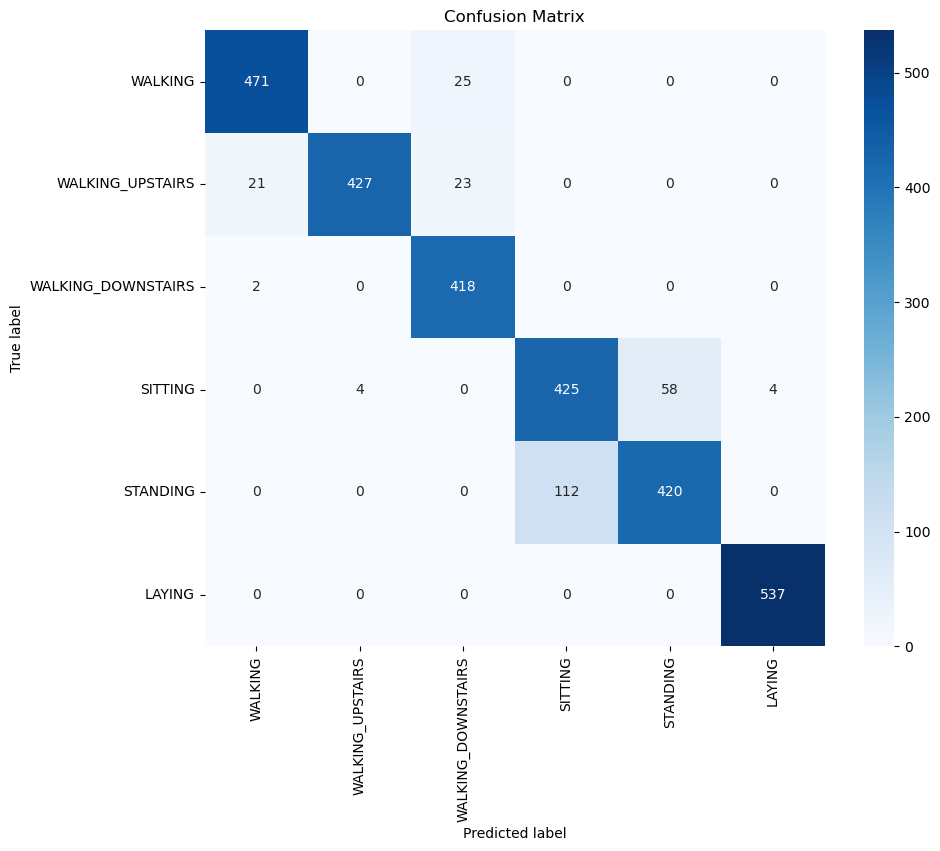

In [22]:
# Confusion Matrix
new_confusion_matrix(Y_test, model.predict(X_test))


In [23]:
score = model.evaluate(X_test, Y_test)
print(f"Loss: {score[0]:.4f}, Accuracy: {score[1]:.4f}")


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8721 - loss: 0.3626
Loss: 0.3206, Accuracy: 0.9155
